# Instead of test the algorithms and affinity on the whole dataset, this notebook test data from each trial, which is what we need in implementation.

# Without anchor object

<IPython.core.display.Javascript object>


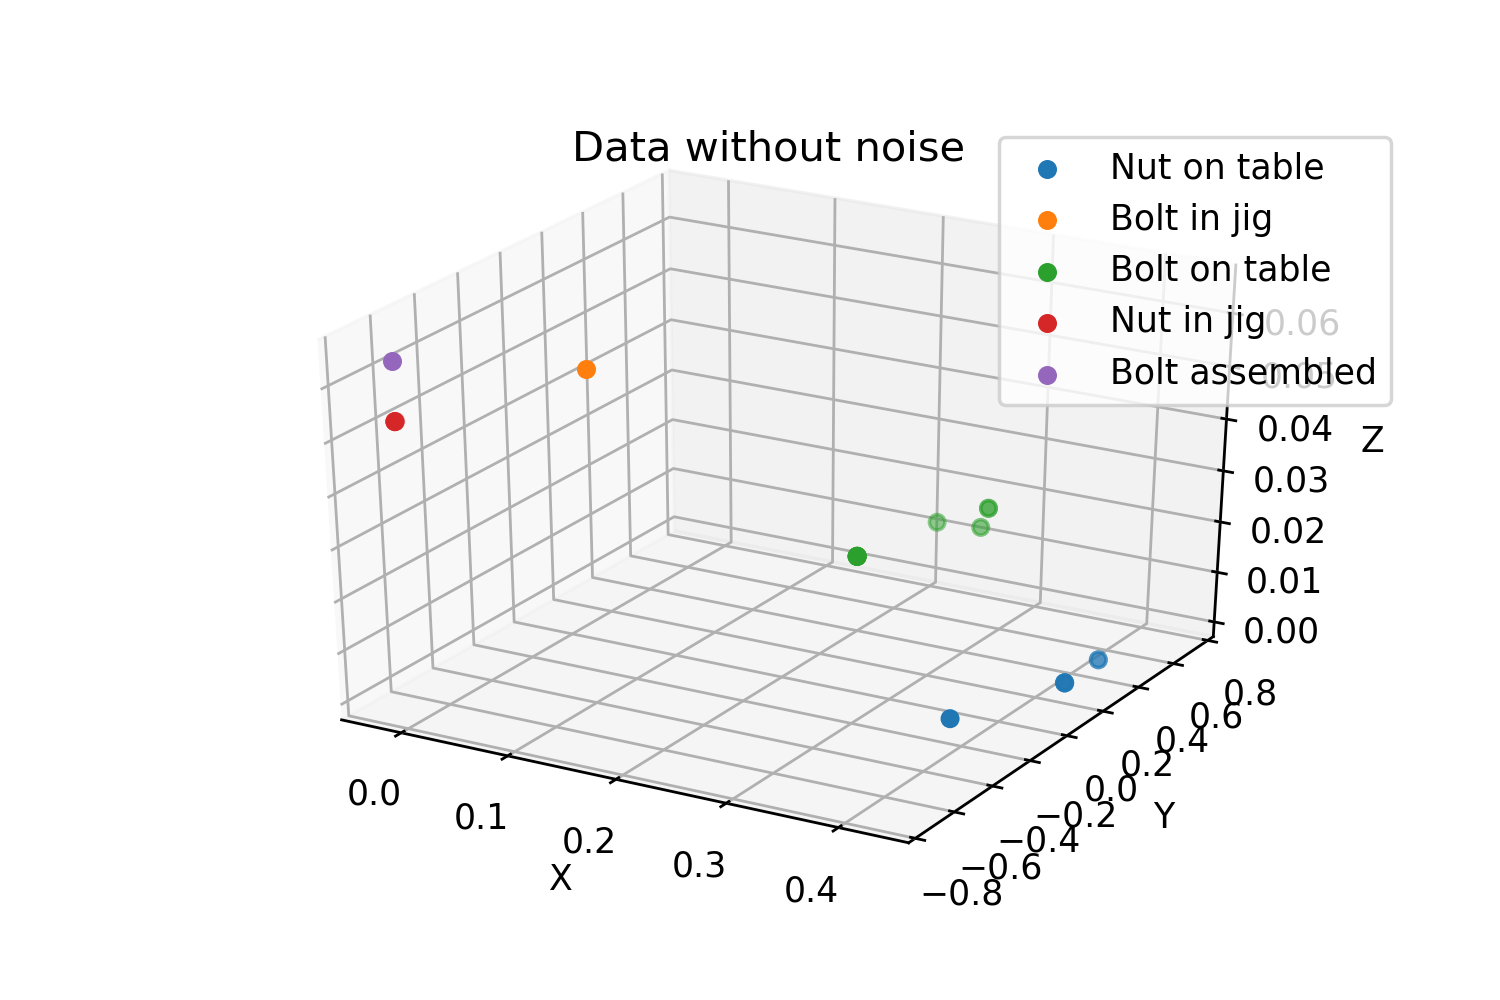

In [1]:
import numpy as np
%matplotlib notebook
import sys
sys.path.append('..')

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from utils.data import fetch_data, fetch_data_with_label, fetch_data_with_label_per_step, generate_data, label_to_int, divide_data
from utils.plotting import plot
from utils.clustering import agglomerative, kmeans, gaussian_mixture, Clustering
from sklearn.metrics import adjusted_rand_score
import itertools


logfile_path = ['../data/raw/1599166289/data.pickle', '../data/raw/1599153598/data.pickle', '../data/raw/test/data.pickle']

#coordinates and object kind for nut and bolt
data_concat, label = fetch_data_with_label_per_step(logfile_path)

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))


coord = selected_data[:,0:3]
obj_kind = selected_data[:, 3]

fig = plt.figure(1, (6,4))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plot(ax, coord, selected_label)
plt.title('Data without noise')
plt.savefig('./figures/data_without_noise.jpg')

In [2]:
ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_label_int = label_to_int(selected_label)

coord = selected_data[:,0:3]
obj_kind = selected_data[:, 3]
        
ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]
label_nut = selected_label[ind_nut]
label_nut_int = label_to_int(label_nut)
label_bolt = selected_label[ind_bolt]
label_bolt_int = label_to_int(label_bolt)
label_concat_int = np.concatenate((label_nut_int, label_bolt_int + len(set(label_nut_int))))

coord_nut = coord[ind_nut]
coord_bolt = coord[ind_bolt]

thres = 0.0009
# thres = np.linspace(0.005,0.015,100)[np.argmax(result)]
estimated_label_nut = agglomerative(coord_nut, 'p_norm', thres)
estimated_label_bolt = agglomerative(coord_bolt, 'p_norm', thres)
estimated_label_concat = np.concatenate((estimated_label_nut, estimated_label_bolt + len(set(estimated_label_nut))))

..\utils\distances.py:11: RuntimeWarning: divide by zero encountered in power
  distances[i,j] = np.sum(difference ** p) ** (1 / p)


In [3]:
print(max(estimated_label_nut), max(estimated_label_bolt))

1 2


<IPython.core.display.Javascript object>


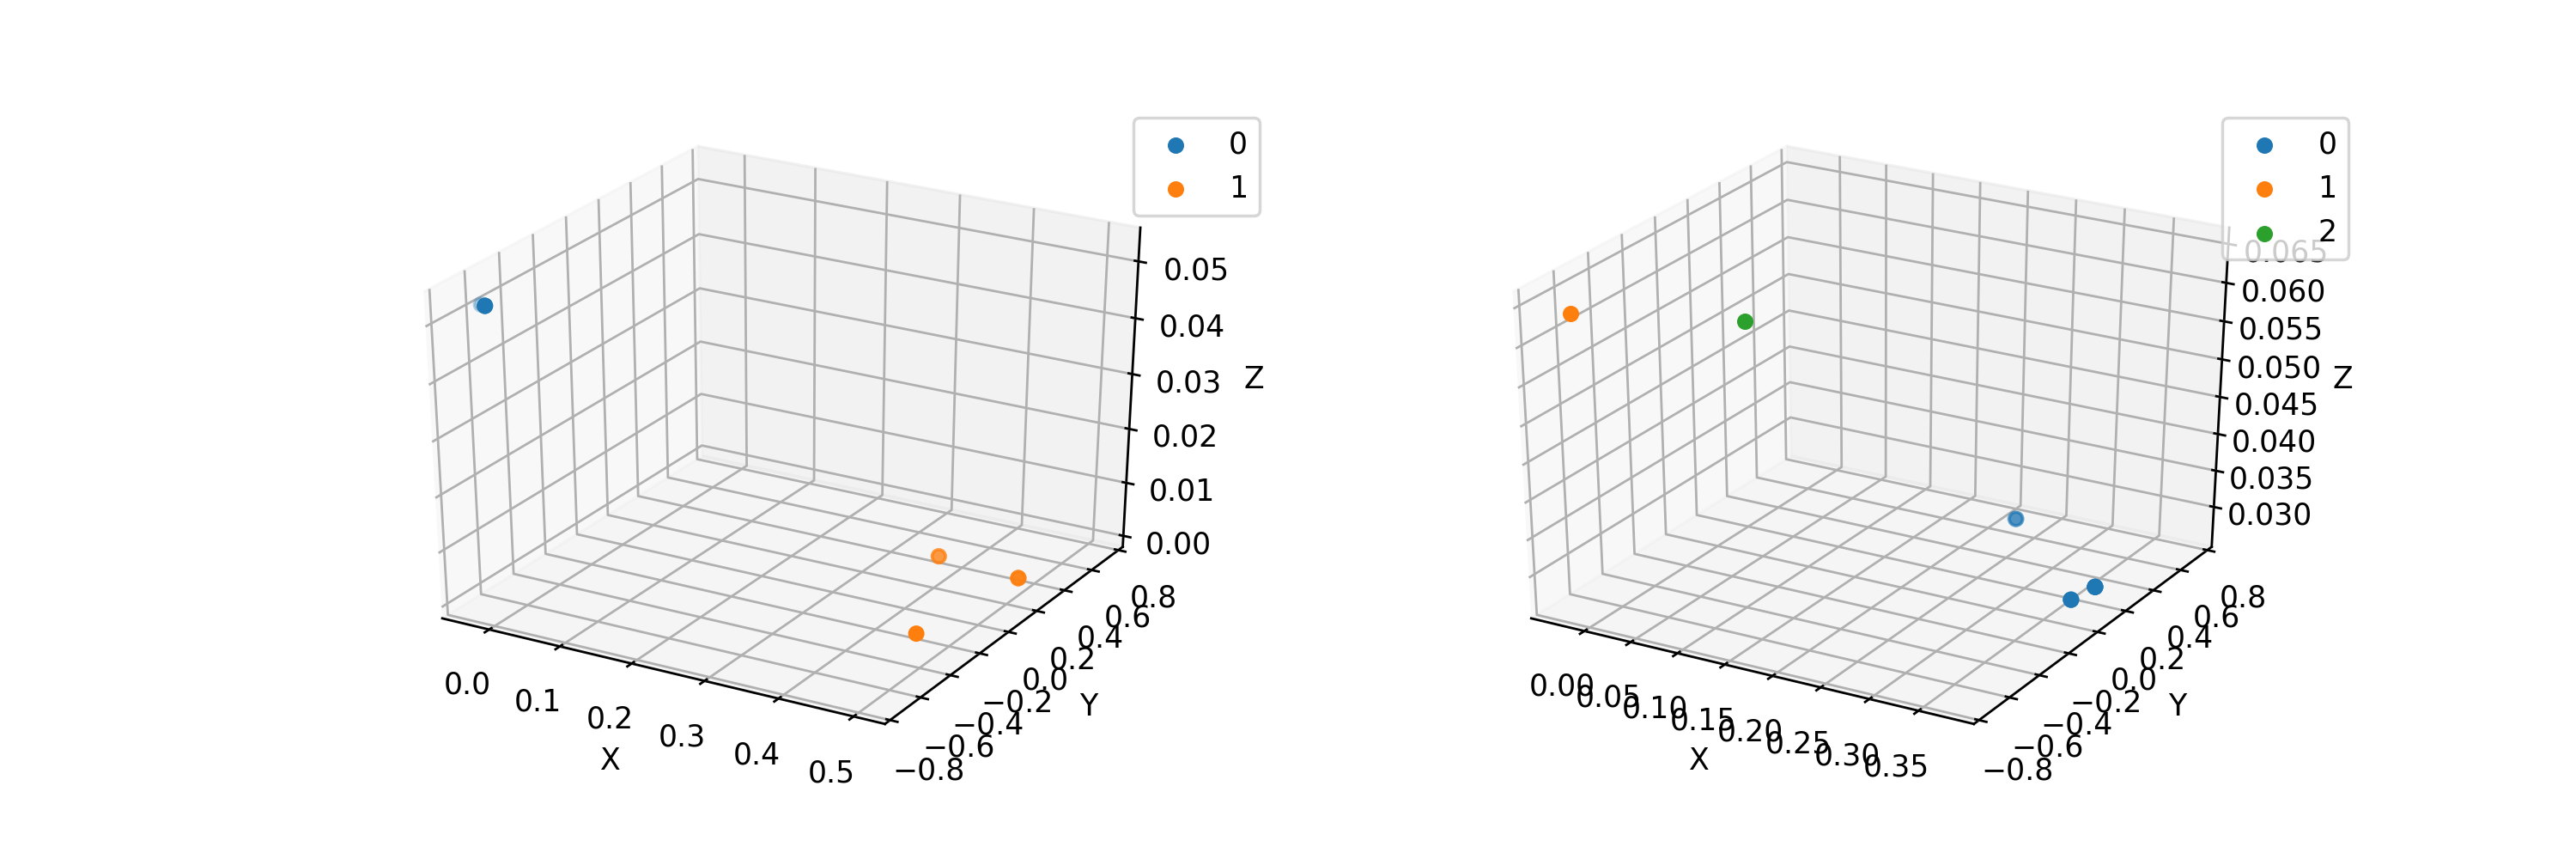

The accuracy for nut is 1.0
The accuracy for bolt is 1.0
The accuracy for nut and bolt is 1.0


In [4]:
fig = plt.figure(2, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_nut, estimated_label_nut)
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_bolt, estimated_label_bolt)
print(f'The accuracy for nut is {adjusted_rand_score(estimated_label_nut, label_nut_int)}')
print(f'The accuracy for bolt is {adjusted_rand_score(estimated_label_bolt, label_bolt_int)}')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, label_concat_int)}')

# Add noise

<IPython.core.display.Javascript object>


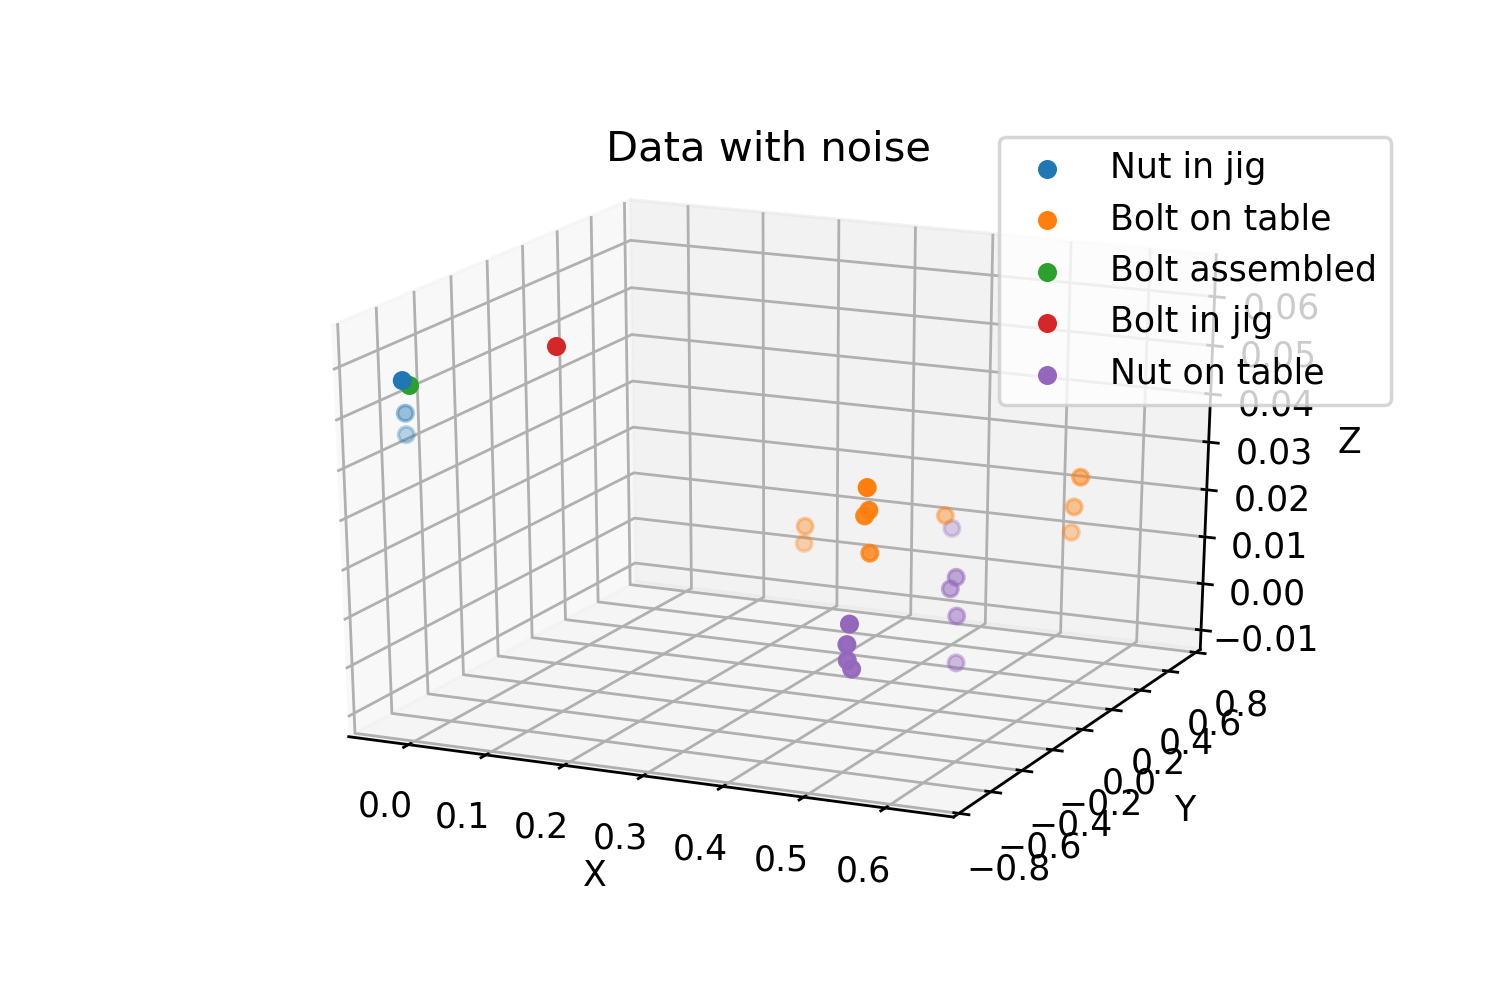

In [11]:
u = 0  # The average shift between the approximated coordinates and ground truth
sigma = 0.006
noise = np.random.normal(u, sigma, coord.shape)
coord_noisy = coord + noise

fig = plt.figure(3, (6,4))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plot(ax, coord_noisy, selected_label)
plt.title('Data with noise')
plt.savefig('./figures/data_with_noise.jpg')

# Agglomerative with P-nom and thres. Object kind is used as a hard constrain.

## Search for thres and p value

In [5]:
def balance_data(data, labels):
    count = []
    for label in set(labels):
        count.append((labels == label).sum())
    max_count = max(count)
    for label in set(labels):
        n_data = (labels == label).sum()
        if n_data < max_count:
            ind = np.where(labels == label)[0]
            selected_data = data[ind, :]
            average = np.average(selected_data, axis = 0)
            n_needed = max_count - n_data
            data_needed = np.tile(average, (n_needed, 1))
            label_needed = np.tile(label, n_needed)
            data = np.concatenate((data, data_needed), axis = 0)
            labels = np.concatenate((labels, label_needed))
    return data, labels

In [6]:
n_test = 10
n_p = 500
n_thres = 500
p_values = np.linspace(-1,-5,n_p) 
thres_values = np.linspace(0.005,0.055,n_thres) 
result = np.zeros((n_p, n_thres))
for i, p_value in enumerate(p_values):
    for j, thres in enumerate(thres_values):
        accuracy = 0
        for k in range(n_test):
            ind = np.random.choice(len(data_concat))
            selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
            selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
            
            selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)

            coord = selected_data_balanced[:,0:3]
            obj_kind = selected_data_balanced[:, 3]

            u = 0  # The average shift between the approximated coordinates and ground truth
            sigma = 0.006
            noise = np.random.normal(u, sigma, coord.shape)
            coord_noisy = coord + noise
           
            ind_nut = np.where(obj_kind == 0)[0]
            ind_bolt = np.where(obj_kind == 1)[0]
            label_nut = selected_label_balanced[ind_nut]
            label_nut_int = label_to_int(label_nut)
            label_bolt = selected_label_balanced[ind_bolt]
            label_bolt_int = label_to_int(label_bolt)
            label_concat_int = np.concatenate((label_nut_int, label_bolt_int + len(set(label_nut_int))))

            coord_nut_noisy = coord_noisy[ind_nut]
            coord_bolt_noisy = coord_noisy[ind_bolt]
            
            estimated_label_nut = agglomerative(coord_nut_noisy, 'p_norm', thres, p = p_value)
            estimated_label_bolt = agglomerative(coord_bolt_noisy, 'p_norm', thres, p = p_value)
            estimated_label_concat = np.concatenate((estimated_label_nut, estimated_label_bolt + len(set(estimated_label_nut))))
            accuracy += adjusted_rand_score(estimated_label_concat, label_concat_int)
        result[i, j] = accuracy/n_test
# np.save('p_value_thres.npy', result)

KeyboardInterrupt: 

In [8]:
obj_kind.shape

(50,)

In [15]:
np.concatenate((coord, obj_kind), axis = 1)

ValueError: all the input arrays must have same number of dimensions

In [14]:
result = np.load('p_value_thres.npy')

In [407]:
ind = np.unravel_index(np.argmax(result, axis=None), np.array(result).shape)
print(ind)
print(f'The best p value is {p_values[ind[0]]}, The best thres is {thres_values[ind[1]]}')

(44, 13)
The best p value is -1.3527054108216432, The best thres is 0.0063026052104208415


In [322]:
p = p_values[ind[0]]
thres = thres_values[ind[1]]

<IPython.core.display.Javascript object>


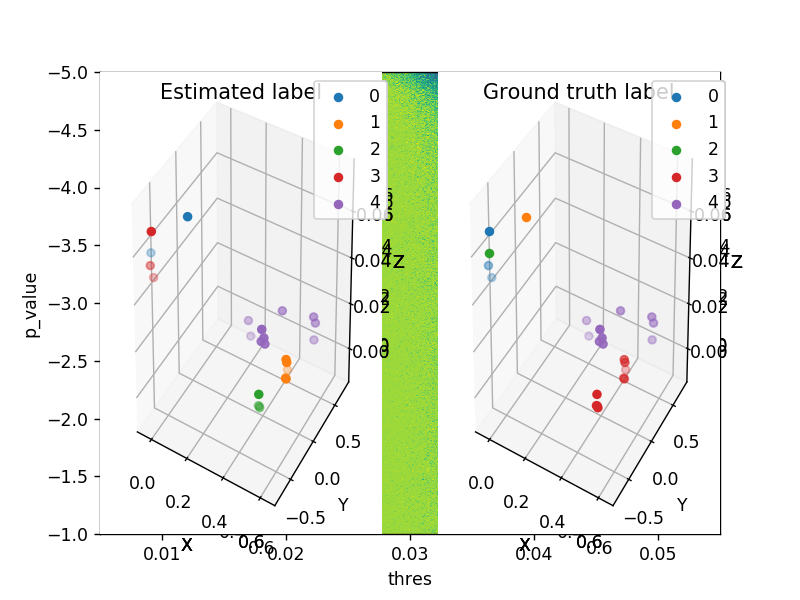

Text(0, 0.5, 'p_value')

In [568]:
plt.figure()
plt.imshow(result, aspect = 'auto', extent = [0.005, 0.055, -1, -5])
plt.xlabel('thres')
plt.ylabel('p_value')

<IPython.core.display.Javascript object>


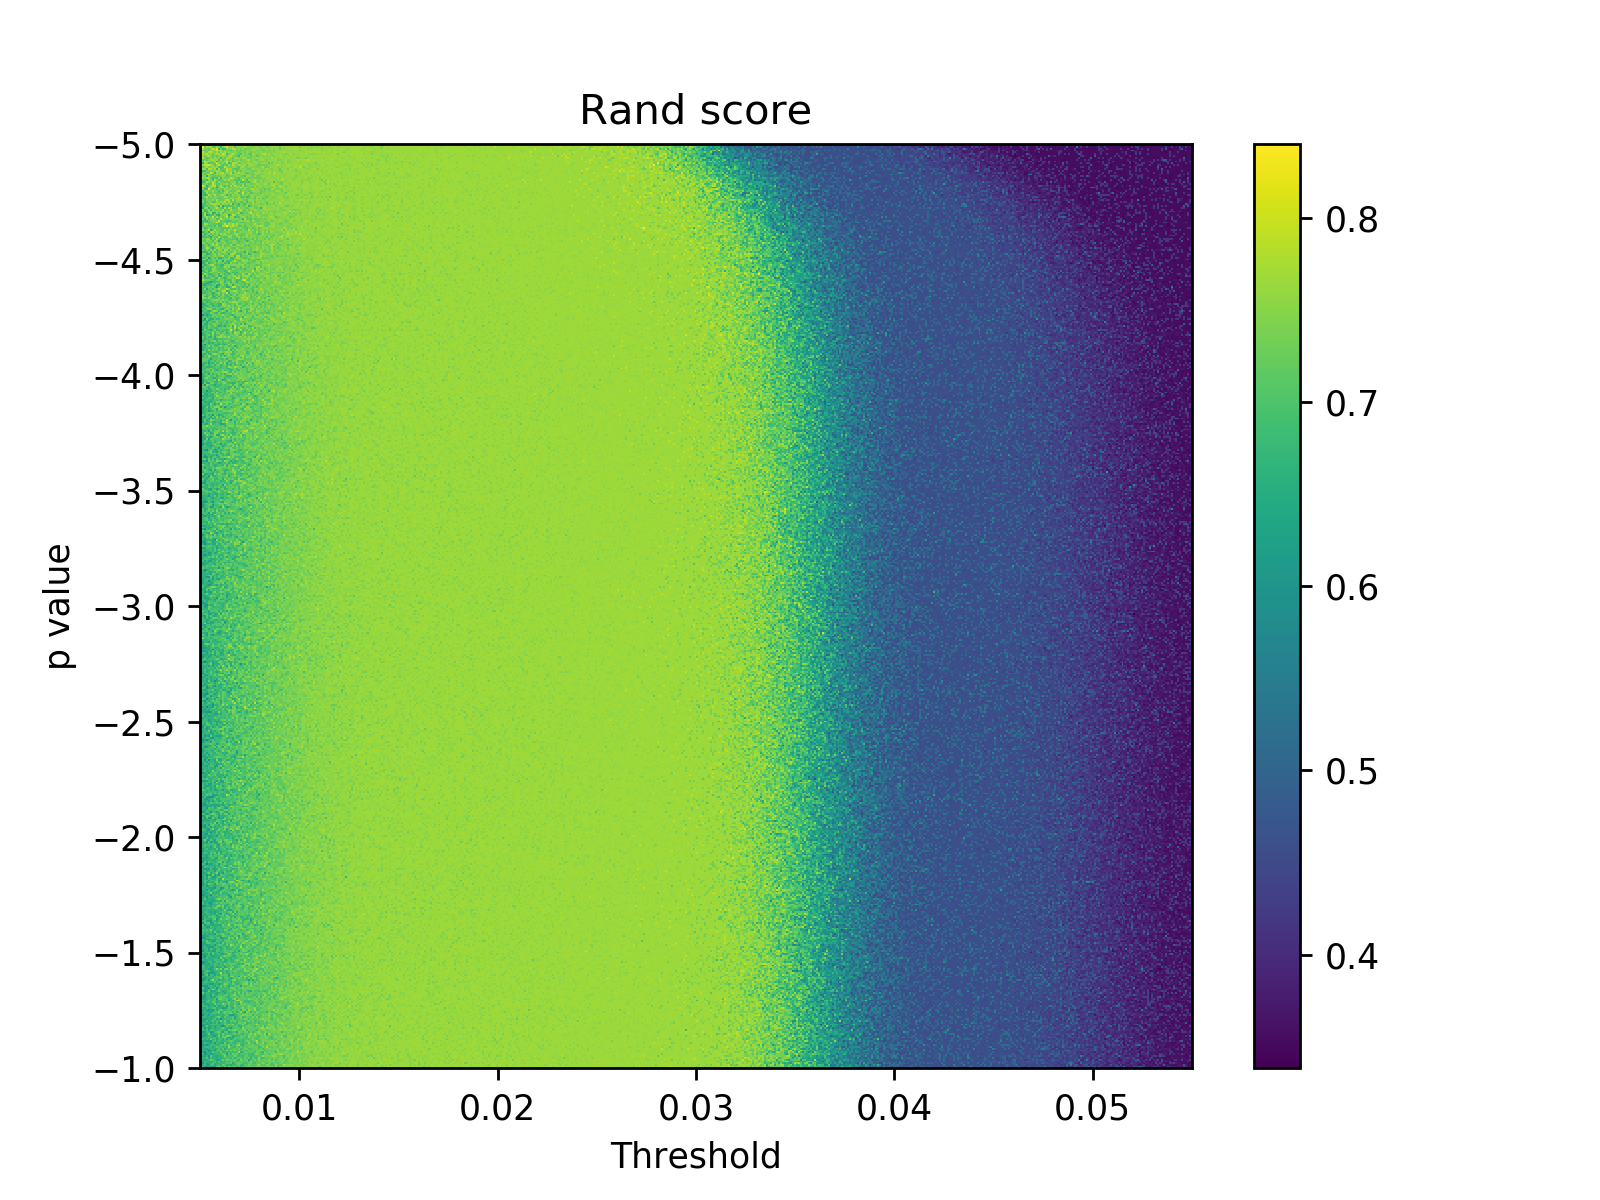

In [21]:
plt.figure()
plt.imshow(result, aspect = 'auto', extent = [0.005, 0.055, -1, -5])
plt.xlabel('Threshold')
plt.ylabel('p value')
plt.title('Rand score')
plt.colorbar()
plt.savefig('./figures/rand_score_heatmap.jpg')

<IPython.core.display.Javascript object>


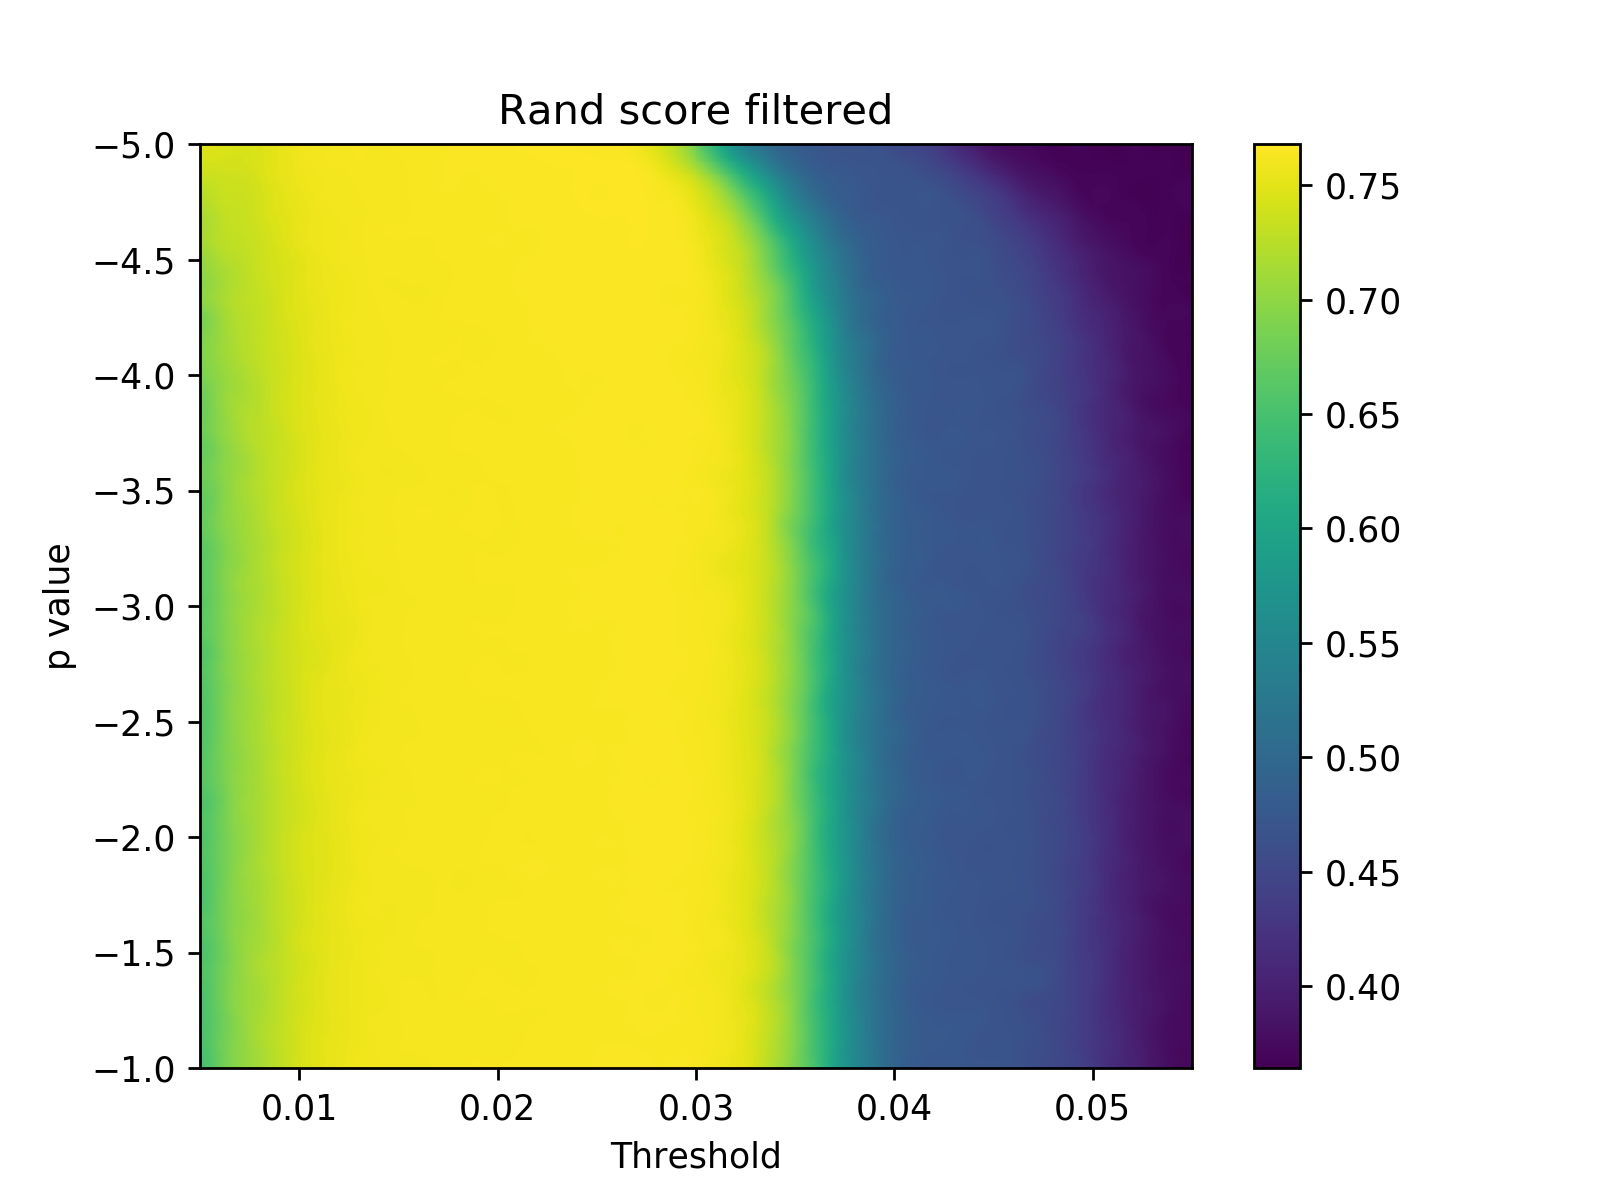

In [22]:
from scipy.ndimage import gaussian_filter
result_filtered = gaussian_filter(result, 5)

plt.figure()
plt.imshow(result_filtered, aspect = 'auto', extent = [0.005, 0.055, -1, -5])
plt.xlabel('Threshold')
plt.ylabel('p value')
plt.title('Rand score filtered')
plt.colorbar()
plt.savefig('./figures/rand_score_filtered_heatmap.jpg')

In [417]:
ind = np.unravel_index(np.argmax(result_filtered, axis=None), np.array(result_filtered).shape)

In [418]:
print(ind)
print(f'The best p value is {p_values[ind[0]]}, The best thres is {thres_values[ind[1]]}')
p = p_values[ind[0]]
thres = thres_values[ind[1]]

(24, 213)
The best p value is -1.1923847695390781, The best thres is 0.026342685370741484


In [35]:
ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_label_int = label_to_int(selected_label)

coord = selected_data[:,0:3]
obj_kind = selected_data[:, 3]
        
u = 0  # The average shift between the approximated coordinates and ground truth
sigma = 0.006
noise = np.random.normal(u, sigma, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]
label_nut = selected_label[ind_nut]
label_nut_int = label_to_int(label_nut)
label_bolt = selected_label[ind_bolt]
label_bolt_int = label_to_int(label_bolt)
label_concat_int = np.concatenate((label_nut_int, label_bolt_int + len(set(label_nut_int))))

coord_nut_noisy = coord_noisy[ind_nut]
coord_bolt_noisy = coord_noisy[ind_bolt]


# thres = np.linspace(0.005,0.015,100)[np.argmax(result)]
thres = 0.012
p = -3
estimated_label_nut = agglomerative(coord_nut_noisy, 'p_norm', thres, p = p)
estimated_label_bolt = agglomerative(coord_bolt_noisy, 'p_norm', thres, p = p)
estimated_label_concat = np.concatenate((estimated_label_nut, estimated_label_bolt + len(set(estimated_label_nut))))

In [36]:
print(max(estimated_label_nut), max(estimated_label_bolt))

1 1


<IPython.core.display.Javascript object>


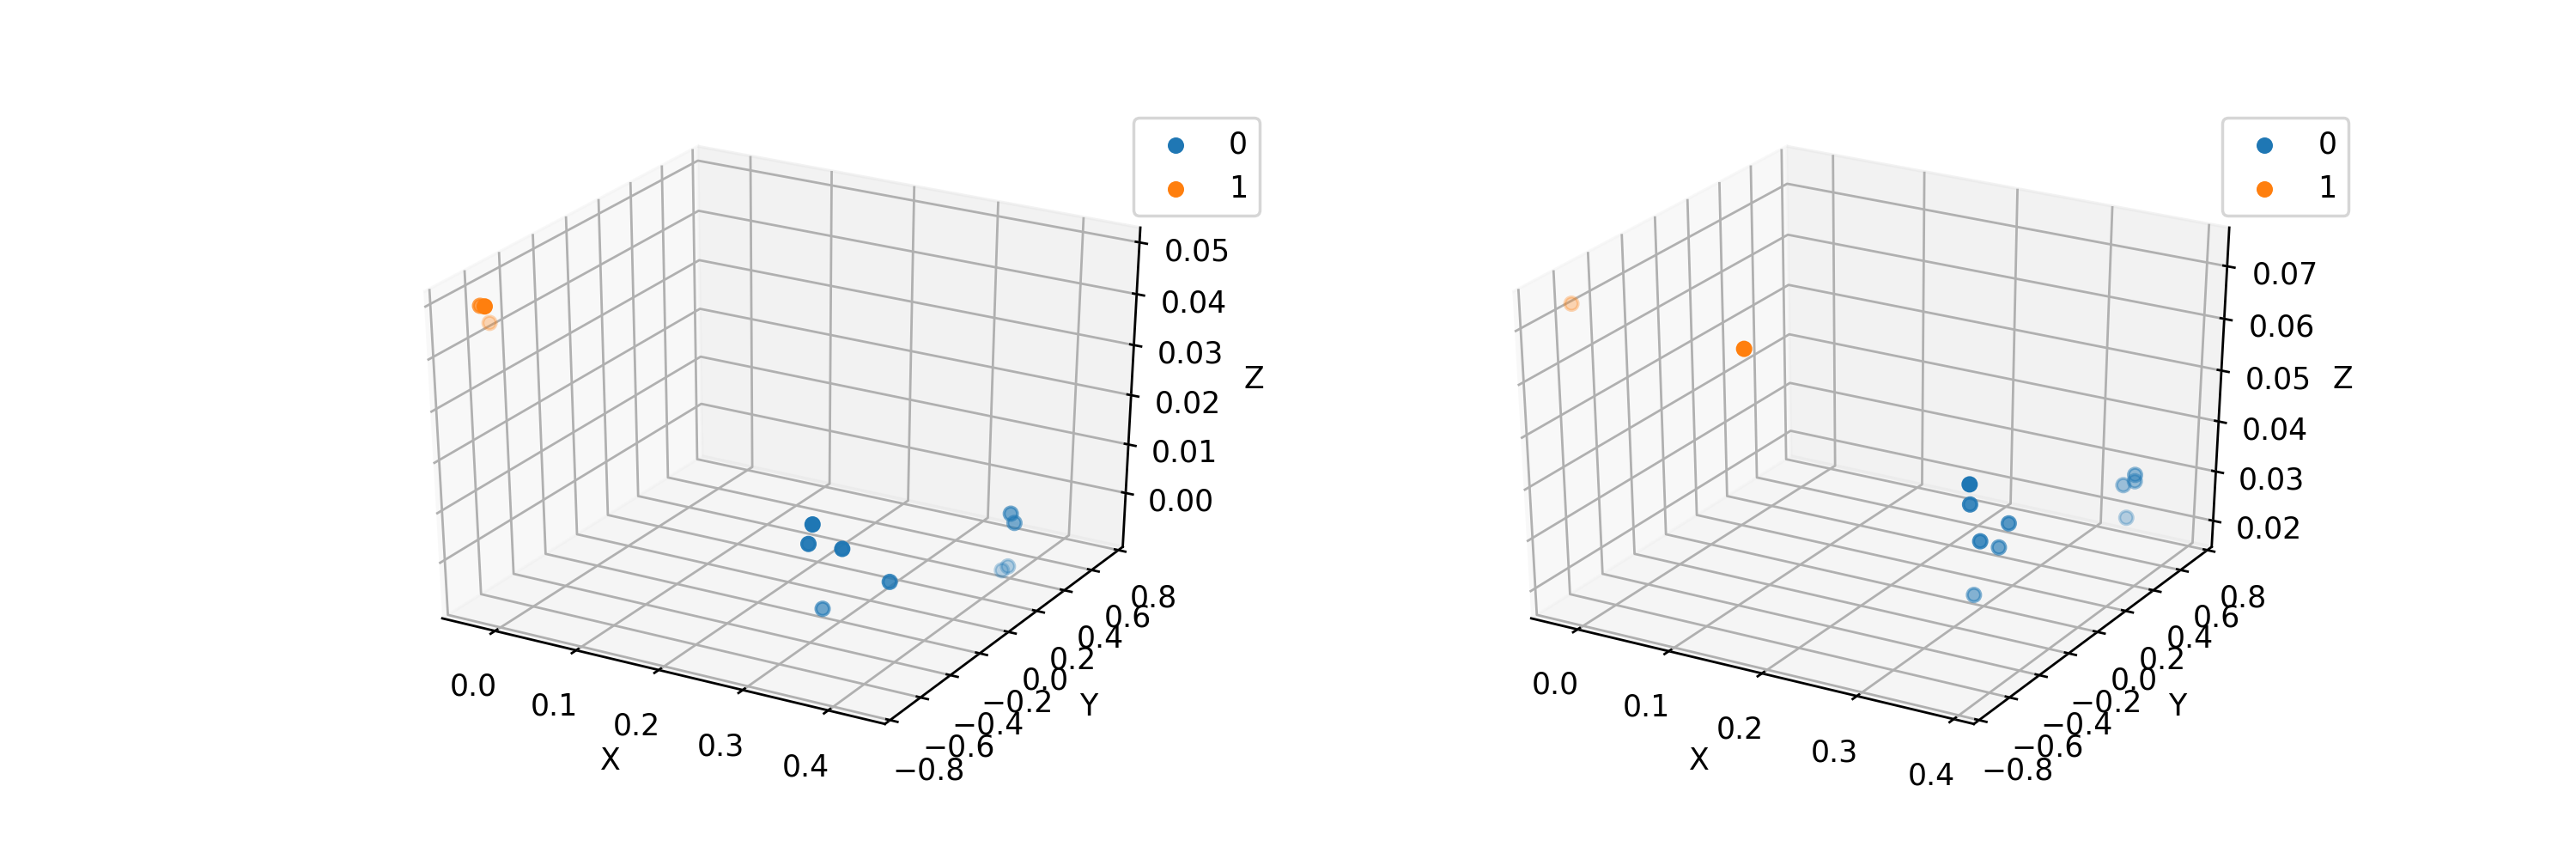

The accuracy for nut is 1.0
The accuracy for bolt is 0.9646302250803859
The accuracy for nut and bolt is 0.9914720059325176


In [40]:
fig = plt.figure(4, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_nut_noisy, estimated_label_nut)
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_bolt_noisy, estimated_label_bolt)
print(f'The accuracy for nut is {adjusted_rand_score(estimated_label_nut, label_nut_int)}')
print(f'The accuracy for bolt is {adjusted_rand_score(estimated_label_bolt, label_bolt_int)}')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, label_concat_int)}')

# Test

In [38]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_label_int = label_to_int(selected_label)

    coord = selected_data[:,0:3]
    obj_kind = selected_data[:, 3]

    u = 0  # The average shift between the approximated coordinates and ground truth
    sigma = 0.006
    noise = np.random.normal(u, sigma, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]
    label_nut = selected_label[ind_nut]
    label_nut_int = label_to_int(label_nut)
    label_bolt = selected_label[ind_bolt]
    label_bolt_int = label_to_int(label_bolt)
    label_concat_int = np.concatenate((label_nut_int, label_bolt_int + len(set(label_nut_int))))

    coord_nut_noisy = coord_noisy[ind_nut]
    coord_bolt_noisy = coord_noisy[ind_bolt]

    thres = 0.012
    p = -3
    estimated_label_nut = agglomerative(coord_nut_noisy, 'p_norm', thres, p = p)
    estimated_label_bolt = agglomerative(coord_bolt_noisy, 'p_norm', thres, p = p)
    estimated_label_concat = np.concatenate((estimated_label_nut, estimated_label_bolt + len(set(estimated_label_nut))))
    accuracy += adjusted_rand_score(estimated_label_concat, label_concat_int)
print(accuracy / n_test)

0.9621514766370087


In [45]:
n_test = 100
accuracy = 0
u_kind = 0.1
sigma_kind = 0.05
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_label_int = label_to_int(selected_label)

    coord = selected_data[:,0:3]
    obj_kind = selected_data[:, 3]

    u = 0  # The average shift between the approximated coordinates and ground truth
    sigma = 0.006
    noise = np.random.normal(u, sigma, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]
    label_nut = selected_label[ind_nut]
    label_nut_int = label_to_int(label_nut)
    label_bolt = selected_label[ind_bolt]
    label_bolt_int = label_to_int(label_bolt)
    label_concat_int = np.concatenate((label_nut_int, label_bolt_int + len(set(label_nut_int))))

    coord_nut_noisy = coord_noisy[ind_nut]
    coord_bolt_noisy = coord_noisy[ind_bolt]
    
    n_data = coord.shape[0]
    one_hot = np.zeros((n_data,2))
    one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))
    
    nut_concat = np.concatenate((coord_nut_noisy, kind_noisy[ind_nut,:]), axis = 1)
    bolt_concat = np.concatenate((coord_bolt_noisy, kind_noisy[ind_bolt,:]), axis = 1)

    thres = 0.012
    p = -3
    estimated_label_nut = agglomerative(nut_concat, 'p_norm', thres, p = p)
    estimated_label_bolt = agglomerative(bolt_concat, 'p_norm', thres, p = p)
    estimated_label_concat = np.concatenate((estimated_label_nut, estimated_label_bolt + len(set(estimated_label_nut))))
    accuracy += adjusted_rand_score(estimated_label_concat, label_concat_int)
print(accuracy / n_test)

0.9232247877605576


# Agglomerative with P-nom and number of clusters. Object kind is used as a soft constrain.

## Search for p value

In [17]:
n_test = 10
result = []
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05

for i in np.linspace(-1,-5, 500):
    accuracy = 0
    for j in range(n_test):
        ind = np.random.choice(len(data_concat))
        selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
        selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
        
        selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
        selected_label_balanced_int = label_to_int(selected_label_balanced)

        coord = selected_data_balanced[:,0:3]
        obj_kind = selected_data_balanced[:, 3]

#         coord = selected_data[:,0:3]
#         obj_kind = selected_data[:, 3]

        noise = np.random.normal(u_coord, sigma_coord, coord.shape)
        coord_noisy = coord + noise

        ind_nut = np.where(obj_kind == 0)[0]
        ind_bolt = np.where(obj_kind == 1)[0]

        n_data = coord.shape[0]
        one_hot = np.zeros((n_data,2))
        one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
        noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
        kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

        coord_concat_ext = np.concatenate((coord_noisy, kind_noisy), axis = 1)
        estimated_label_concat = agglomerative(coord_concat_ext, 'p_norm', thres = None, n_clusters = 5, p = i)
        accuracy += adjusted_rand_score(estimated_label_concat, selected_label_balanced_int)
    result.append(accuracy/n_test) 

KeyboardInterrupt: 

In [616]:
ind = np.argmax(result)
best_p = np.linspace(-1,-5, 500)[ind]
print(f'The best p value is {best_p}')

The best p value is -1.0240480961923848


<IPython.core.display.Javascript object>


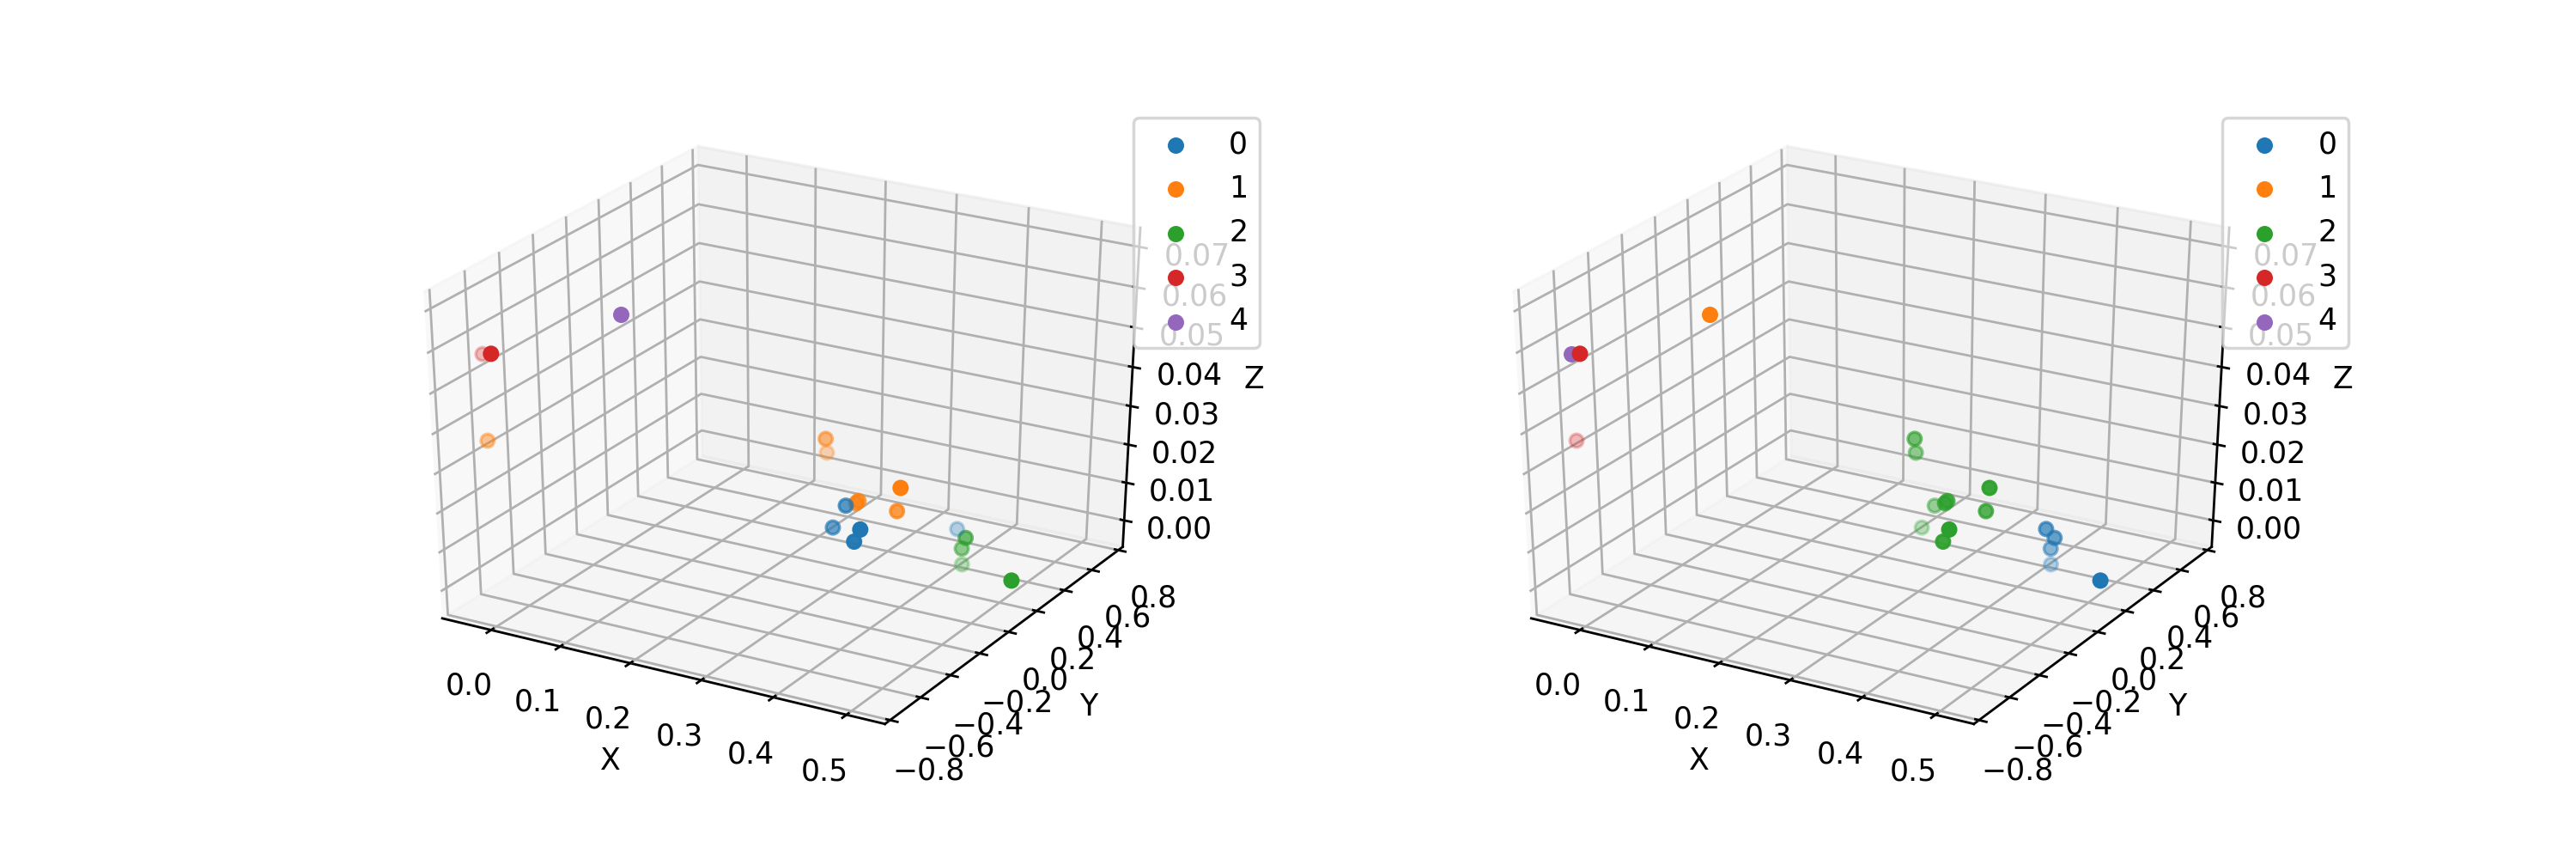

The accuracy for nut and bolt is 0.42122186495176844


In [18]:
ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_label_int = label_to_int(selected_label)

coord = selected_data[:,0:3]
obj_kind = selected_data[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot = np.zeros((n_data,2))
one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

coord_concat_ext = np.concatenate((coord_noisy, kind_noisy), axis = 1)

estimated_label_concat = agglomerative(coord_concat_ext, 'p_norm', thres = None, n_clusters = 5, p = -2)

fig = plt.figure(5, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy, estimated_label_concat)
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy, selected_label_int)
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, selected_label_int)}')

# Test

In [51]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_label_int = label_to_int(selected_label)

    coord = selected_data[:,0:3]
    obj_kind = selected_data[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot = np.zeros((n_data,2))
    one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

    coord_concat_ext = np.concatenate((coord_noisy, kind_noisy), axis = 1)

    estimated_label_concat = agglomerative(coord_concat_ext, 'p_norm', thres = None, n_clusters = 5, p = -2)
    accuracy += adjusted_rand_score(estimated_label_concat, selected_label_int)
    
print(accuracy / n_test)

0.7048048548882232


# Agglomerative with Euclidean and number of clusters. Object kind is used as a soft constrain.

In [679]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_label_int = label_to_int(selected_label)

    coord = selected_data[:,0:3]
    obj_kind = selected_data[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot = np.zeros((n_data,2))
    one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

    coord_concat_ext = np.concatenate((coord_noisy, kind_noisy), axis = 1)

    estimated_label_concat = agglomerative(coord_concat_ext, 'euclidean', thres = None, n_clusters = 5, p = 2)
    accuracy += adjusted_rand_score(estimated_label_concat, selected_label_int)
    
print(accuracy / n_test)

0.8091356111980842


<IPython.core.display.Javascript object>


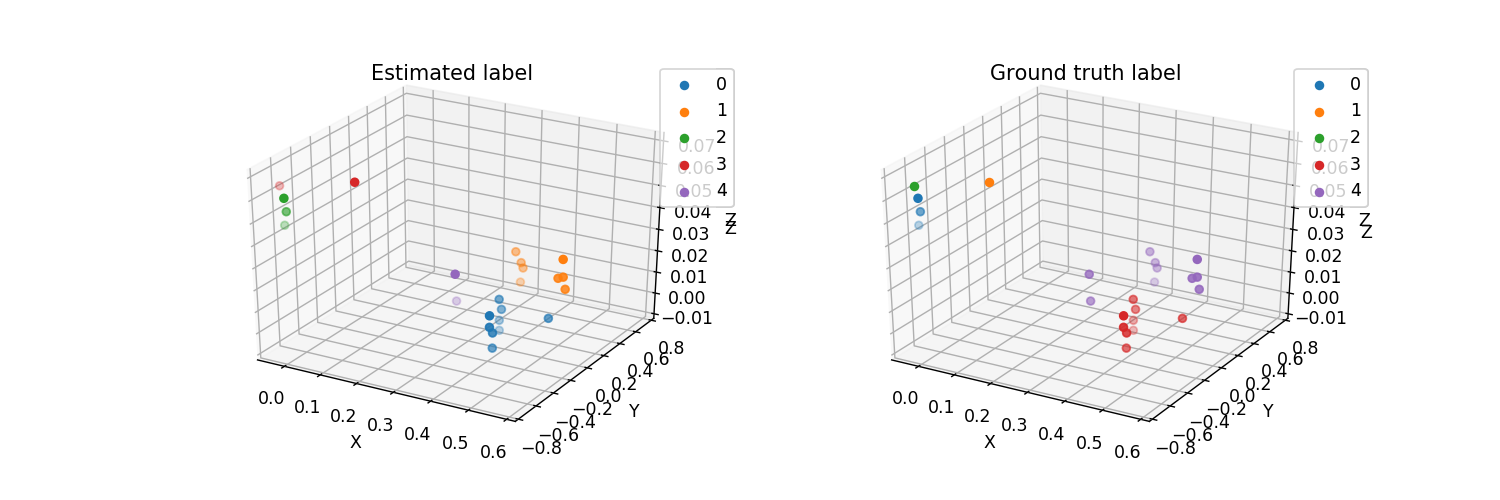

The accuracy for nut and bolt is 0.8468468468468469


In [680]:
ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_label_int = label_to_int(selected_label)

coord = selected_data[:,0:3]
obj_kind = selected_data[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot = np.zeros((n_data,2))
one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

coord_concat_ext = np.concatenate((coord_noisy, kind_noisy), axis = 1)
estimated_label_concat = agglomerative(coord_concat_ext, 'euclidean', thres = None, n_clusters = 5, p = 2)

fig = plt.figure(6, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy, estimated_label_concat)
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy, selected_label_int)
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, selected_label_int)}')

# Agglomerative with Cosine and number of clusters. Object kind is used as a soft constrain.

In [693]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_label_int = label_to_int(selected_label)

    coord = selected_data[:,0:3]
    obj_kind = selected_data[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot = np.zeros((n_data,2))
    one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

    coord_concat_ext = np.concatenate((coord_noisy, kind_noisy), axis = 1)

    estimated_label_concat = agglomerative(coord_concat_ext, 'cosine', thres = None, n_clusters = 5, p = 2)
    accuracy += adjusted_rand_score(estimated_label_concat, selected_label_int)
    
print(accuracy / n_test)

0.7986582347786739


<IPython.core.display.Javascript object>


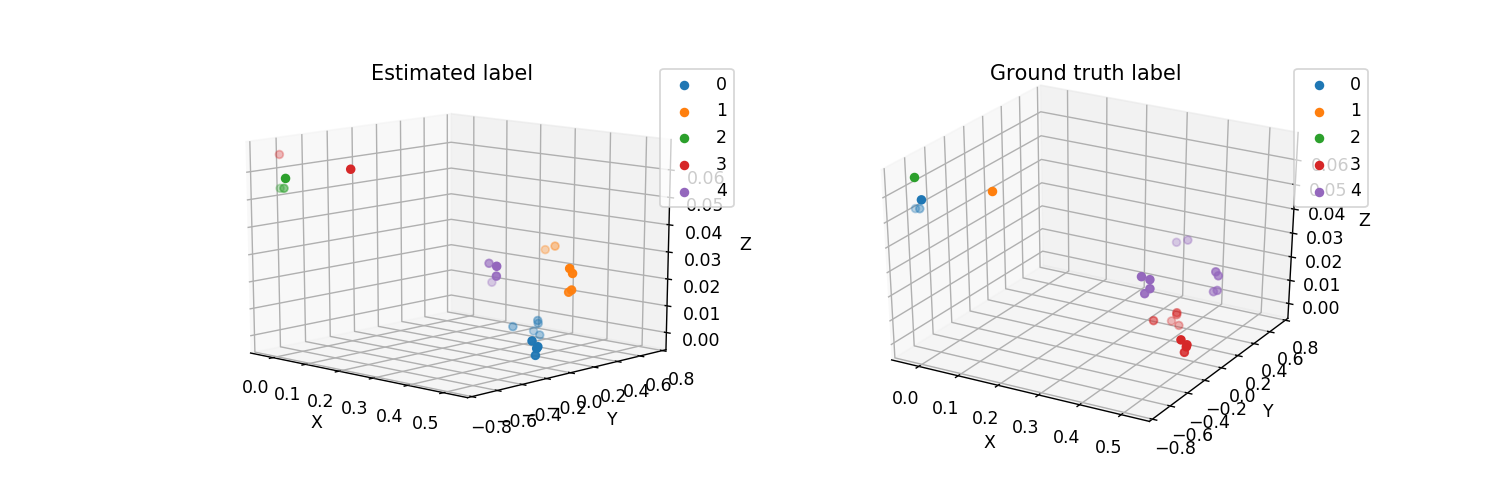

The accuracy for nut and bolt is 0.7682386134623136


In [694]:
ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_label_int = label_to_int(selected_label)

coord = selected_data[:,0:3]
obj_kind = selected_data[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot = np.zeros((n_data,2))
one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

coord_concat_ext = np.concatenate((coord_noisy, kind_noisy), axis = 1)
estimated_label_concat = agglomerative(coord_concat_ext, 'cosine', thres = None, n_clusters = 5, p = 2)

fig = plt.figure(7, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy, estimated_label_concat)
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy, selected_label_int)
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, selected_label_int)}')

# Kmeans with p_norm and number of clusters. 

..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)


<IPython.core.display.Javascript object>


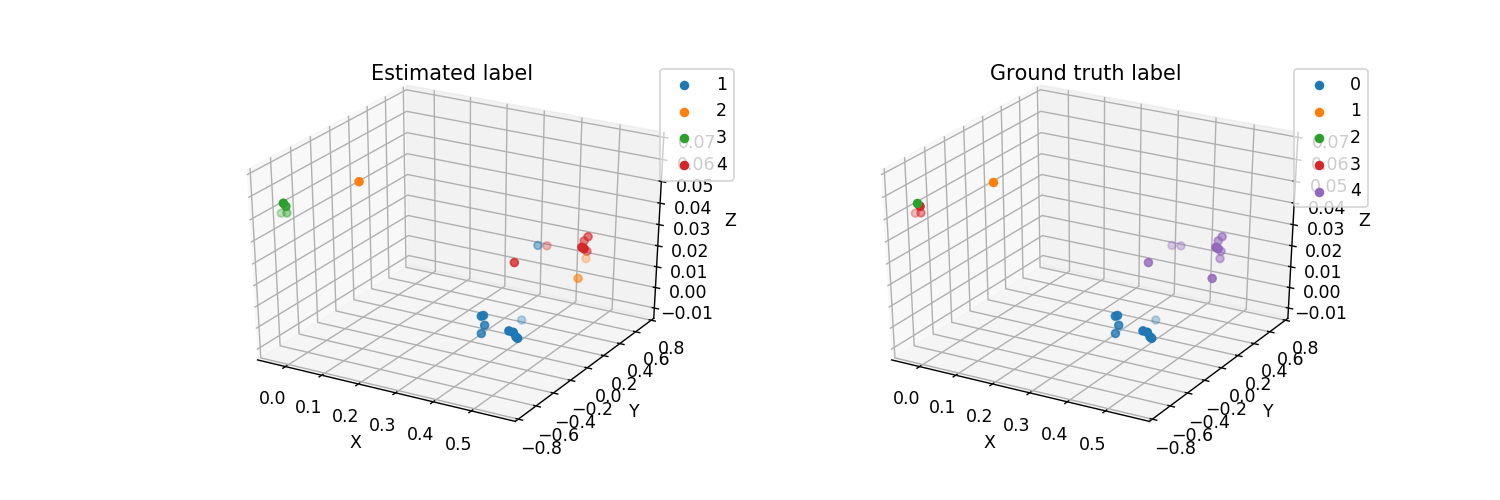

The accuracy for nut and bolt is 0.6735711545838128


In [7]:
ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot = np.zeros((n_data,2))
one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

coord_concat_ext = np.concatenate((coord_noisy, kind_noisy), axis = 1)
estimated_label_concat, centers = kmeans(coord_concat_ext, n_clusters = 5, affinity = 'p_norm', p = -2)


n_original = selected_data.shape[0]
fig = plt.figure(8, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])}')

In [727]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot = np.zeros((n_data,2))
    one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

    coord_concat_ext = np.concatenate((coord_noisy, kind_noisy), axis = 1)
    estimated_label_concat, centers = kmeans(coord_concat_ext, n_clusters = 5, affinity = 'p_norm', p = -2)


    n_original = selected_data.shape[0]
    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(differen

..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='un

..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(differen

..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
C:\Users\xyao0\Anaconda3\lib\site-p

0.5304310902875627


# Kmeans with Euclidean and number of clusters. 

<IPython.core.display.Javascript object>


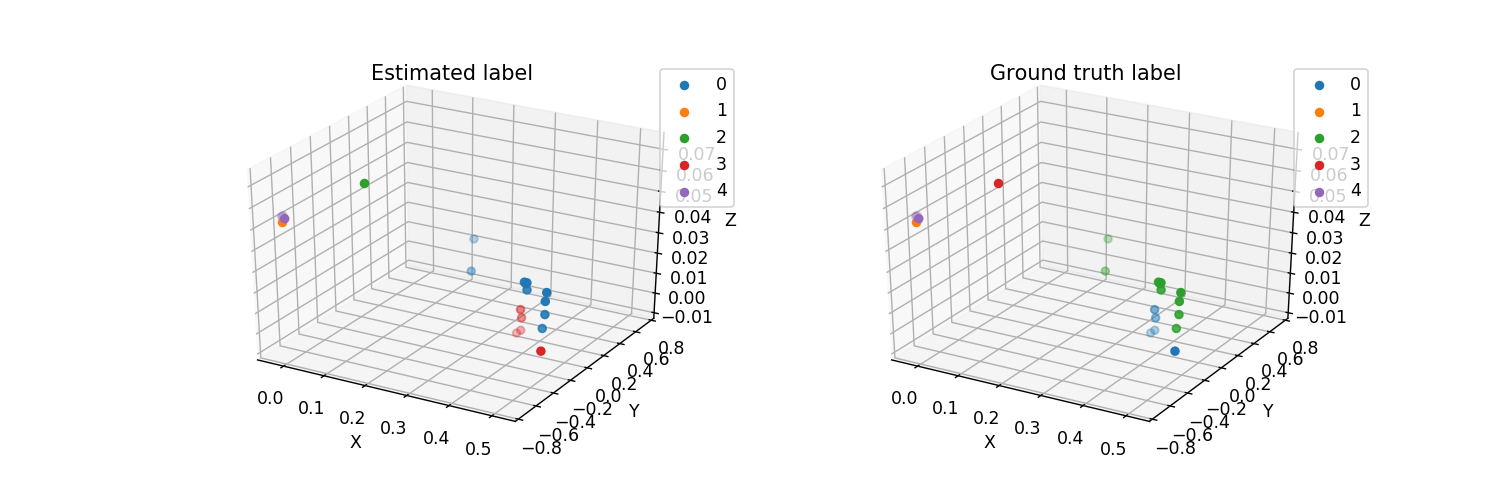

The accuracy for nut and bolt is 1.0


In [65]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot = np.zeros((n_data,2))
one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

coord_concat_ext = np.concatenate((coord_noisy, kind_noisy), axis = 1)
estimated_label_concat, centers = kmeans(coord_concat_ext, n_clusters = 5, affinity = 'euclidean')


n_original = selected_data.shape[0]
fig = plt.figure(11, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])}')

In [5]:
n_test = 100
accuracy = 0
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot = np.zeros((n_data,2))
    one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

    coord_concat_ext = np.concatenate((coord_noisy, kind_noisy), axis = 1)
    estimated_label_concat, centers = kmeans(coord_concat_ext, n_clusters = 5, affinity = 'euclidean')


    n_original = selected_data.shape[0]
    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.8900863809039307


# Kmeans with cosine and number of clusters. 

<IPython.core.display.Javascript object>


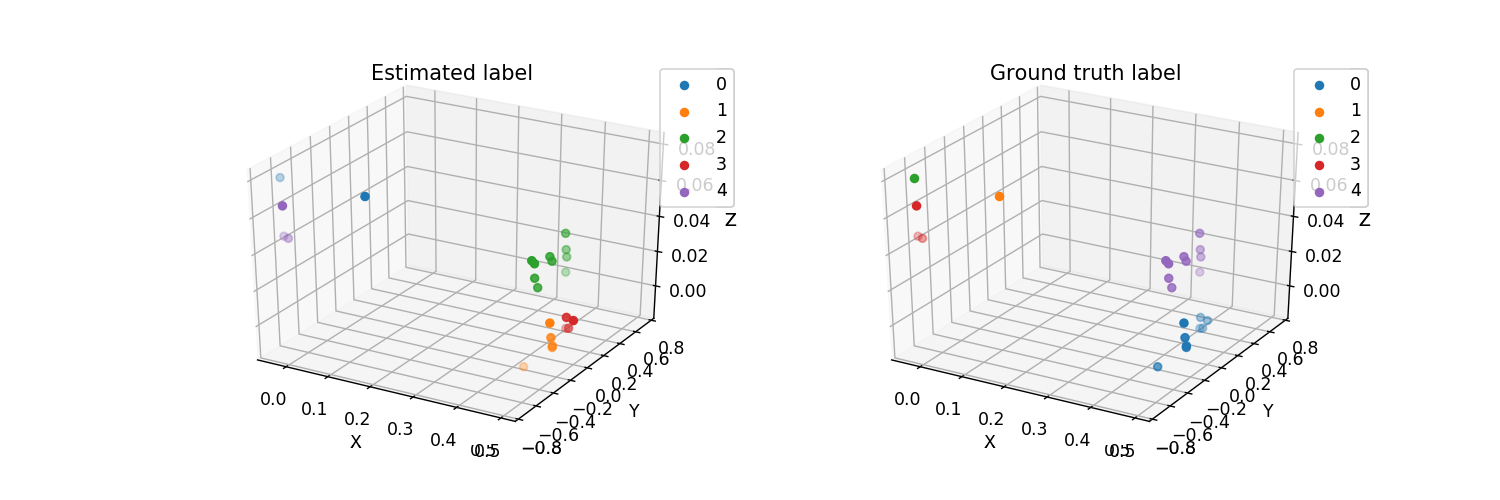

The accuracy for nut and bolt is 0.7268408551068883


In [11]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot = np.zeros((n_data,2))
one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

coord_concat_ext = np.concatenate((coord_noisy, kind_noisy), axis = 1)
estimated_label_concat, centers = kmeans(coord_concat_ext, n_clusters = 5, affinity = 'cosine')


n_original = selected_data.shape[0]
fig = plt.figure(12, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])}')

In [12]:
n_test = 100
accuracy = 0
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot = np.zeros((n_data,2))
    one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

    coord_concat_ext = np.concatenate((coord_noisy, kind_noisy), axis = 1)
    estimated_label_concat, centers = kmeans(coord_concat_ext, n_clusters = 5, affinity = 'cosine')


    n_original = selected_data.shape[0]
    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.8341179335957011


# Gaussian mixture model

<IPython.core.display.Javascript object>


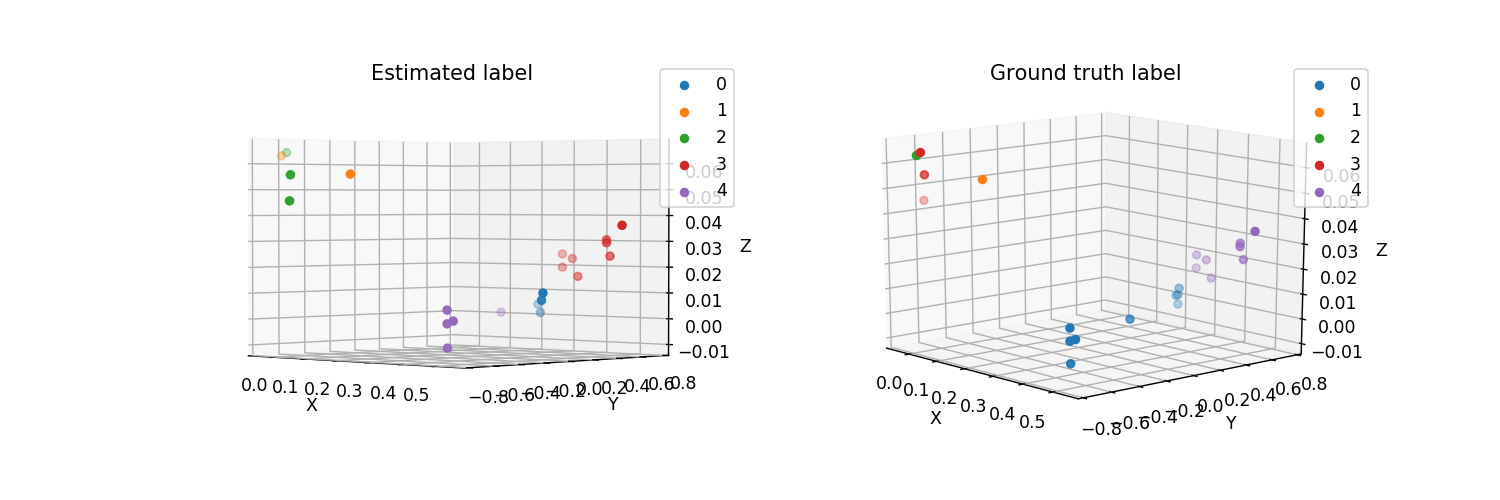

The accuracy for nut and bolt is 0.7590523021904336


In [22]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot = np.zeros((n_data,2))
one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

coord_concat_ext = np.concatenate((coord_noisy, kind_noisy), axis = 1)
estimated_label_concat, centers = gaussian_mixture(coord_concat_ext, n_clusters = 5)


n_original = selected_data.shape[0]
fig = plt.figure(13, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])}')

In [18]:
n_test = 100
accuracy = 0
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot = np.zeros((n_data,2))
    one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

    coord_concat_ext = np.concatenate((coord_noisy, kind_noisy), axis = 1)
    estimated_label_concat, centers = gaussian_mixture(coord_concat_ext, n_clusters = 5)


    n_original = selected_data.shape[0]
    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.827447228702351
